## Imports

In [64]:
from DataProvider import DataProvider
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import random

# SEED

In [65]:
SEED = 555555
if not SEED:
    SEED = random.randint(1, 99999)

tf.keras.utils.set_random_seed(SEED)

print(f"SEED: {SEED}")

SEED: 555555


## Data

In [66]:
dataProvider = DataProvider()

[Getting raw data...]
[Preprocessing...]
[Data Provider ready]


In [67]:
train, test = dataProvider.get_train_test_sets(proportions=0.7)

In [68]:
x_train, y_train = dataProvider.get_x_and_y(train)
x_test, y_test = dataProvider.get_x_and_y(test)

# LSTM model + optymalizacja hiperparametrów

Optymalizacja hiperparametrów przeprowadzana jest za pomocą metody siatki hiperparametrów, gdzie pod uwagę brana jest liczba neuronów warstwy ukrytej lstm i learning rate optymalizatora

In [69]:
def model_builder(hp):
    lstm_model = tf.keras.Sequential()
    
    # Tune the number of units in the lstm layer
    # Choose an optimal value between 1-257
    hp_units_lstm = hp.Int('units', min_value=1, max_value=257, step=32)
    lstm_model.add(layers.LSTM(units=hp_units_lstm, activation='relu', input_shape=(None, 1)))

    lstm_model.add(layers.Dense(1))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.005, 0.001, 0.0005 or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3, 5e-4, 1e-4])
    lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                       loss=tf.keras.losses.MeanSquaredError(),
                       metrics=['accuracy'])
    
    return lstm_model

In [70]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("val_loss", direction="min"),
                     max_epochs=20,
                     factor=3,
                     directory='./parameter_tuing',
                     project_name='Popularity_classification',
                     seed=SEED)

# Stop early if the model is not improving
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

INFO:tensorflow:Reloading Tuner from ./parameter_tuing\Popularity_classification\tuner0.json


INFO:tensorflow:Reloading Tuner from ./parameter_tuing\Popularity_classification\tuner0.json


In [71]:
tuner.search(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the lstm
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 225 and the optimal learning rate for the optimizer
is 0.001.



In [72]:
lstm_model = tuner.hypermodel.build(best_hps)

## Train

In [73]:
lstm_model.fit(x_train, y_train, epochs=20, verbose=1)
lstm_model.save('./lstm_save')

Epoch 1/20
5/5 [==============================] - 1s 12ms/step - loss: 17639.0117 - accuracy: 0.0000e+00
Epoch 2/20
5/5 [==============================] - 0s 11ms/step - loss: 6602.1860 - accuracy: 0.0000e+00
Epoch 3/20
5/5 [==============================] - 0s 12ms/step - loss: 1350.9856 - accuracy: 0.0000e+00
Epoch 4/20
5/5 [==============================] - 0s 13ms/step - loss: 877.3267 - accuracy: 0.0000e+00
Epoch 5/20
5/5 [==============================] - 0s 16ms/step - loss: 842.7531 - accuracy: 0.0000e+00
Epoch 6/20
5/5 [==============================] - 0s 12ms/step - loss: 771.6596 - accuracy: 0.0000e+00
Epoch 7/20
5/5 [==============================] - 0s 15ms/step - loss: 754.7744 - accuracy: 0.0000e+00
Epoch 8/20
5/5 [==============================] - 0s 11ms/step - loss: 712.8107 - accuracy: 0.0000e+00
Epoch 9/20
5/5 [==============================] - 0s 10ms/step - loss: 698.7867 - accuracy: 0.0000e+00
Epoch 10/20
5/5 [==============================] - 0s 11ms/step - los

INFO:tensorflow:Assets written to: ./lstm_save\assets


INFO:tensorflow:Assets written to: ./lstm_save\assets


## Eval

In [74]:
def MSE(x, y):
    mse = (np.square(x - y)).mean(axis=-1)
    return mse

In [96]:
from main_models import LinearRegressionModel

naive_model = LinearRegressionModel()
y_preds = []
for x, y in zip(x_test, y_test):
    y_pred = naive_model.predict(x.reshape((x.size)), 1)
    y_preds.append(y_pred[-1])

print(f"MSE - naive: {MSE(y_preds, y_test)}")

MSE - naive: 1283.3469113569847


In [98]:
predictions = lstm_model.predict(x_test, verbose=1)
predictions = predictions.reshape((predictions.size))
print(f"MSE - LSTM: {MSE(predictions, y_test)}")


2/2 [==============================] - 0s 7ms/step
MSE - LSTM: 687.3561040972294


# Visualization

In [76]:
from sklearn.linear_model import LinearRegression
import pandas as pd
# Naive model
class LinearRegressionModel:
    def __init__(self):
        self._model = LinearRegression()
    
    def fit(self, x, y):
        self._model.fit(x, y)
    
    def predict(self, x):
        return self._model.predict(np.array(x).reshape((-1, 1)))

### Function for visualizing comparasion

In [77]:
def plot_comparison(artist, input, label, future_points=5):
    # Naive model
    naive_input = input.reshape((11))
    naive_model = LinearRegressionModel()
    naive_model.fit(np.array(range(naive_input.size)).reshape(-1, 1), naive_input)
    naive_predictions = pd.Series(naive_model.predict(x) for x in range(len(input) + future_points))
    
    # LSTM model
    lstm_predictions = [x for x in input]
    for n in range(future_points):
        reshaped_input = np.array(lstm_predictions).reshape((1, len(lstm_predictions), 1))
        prediction = lstm_model.predict(reshaped_input)[0]
        lstm_predictions.append(prediction)

    plt.figure(figsize=(15,8))
    plt.locator_params(axis='y', nbins=20)
    plt.title(f"Artist: {artist}")
    plt.xlabel("Week [ordered Number]")
    plt.ylabel("Play time [minutes]")
    # Naive prediction
    plt.plot(naive_predictions, label="Naive prediction", marker='o', color='green')
    # LSTM prediction
    plt.plot(lstm_predictions, label="LSTM prediction", marker='o', color='blue')
    # Past and current
    plt.plot(pd.Series(input.reshape(11)), label="Actual data", marker='o', color='black')
    # Future
    plt.plot([len(input) - 1, len(input)], [input[-1][0], label], label="Future", marker='o', color='red')
    plt.text(len(input)/2, naive_input[2],
             f"MSE loss for Naive: {MSE(label, naive_predictions[len(naive_predictions)-future_points]):>10.2f}\n"
           + f"MSE loss for LSTM: {MSE(label, lstm_predictions[-future_points]):>10.2f}",
             style='italic', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
    plt.grid()
    plt.legend()


1/1 [==============================] - 0s 19ms/step


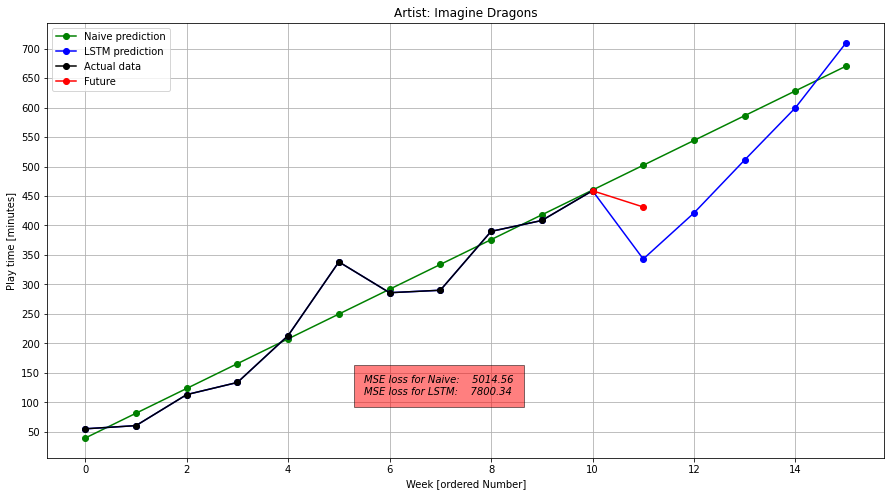

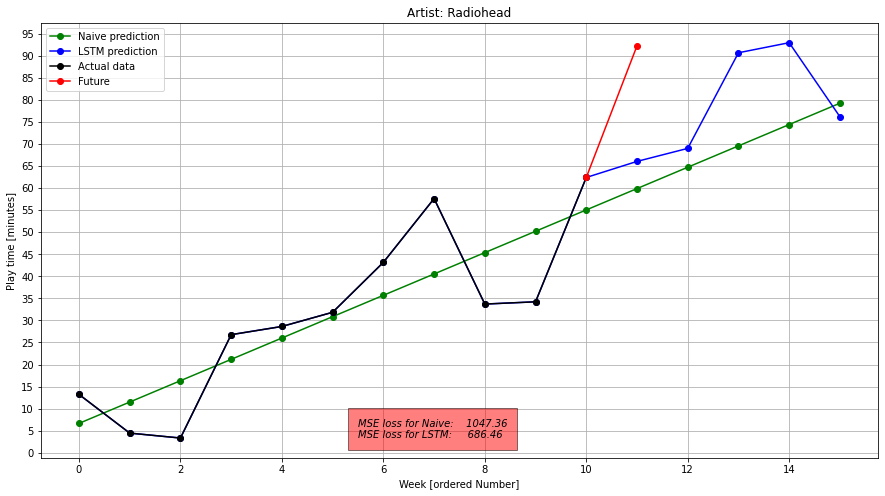

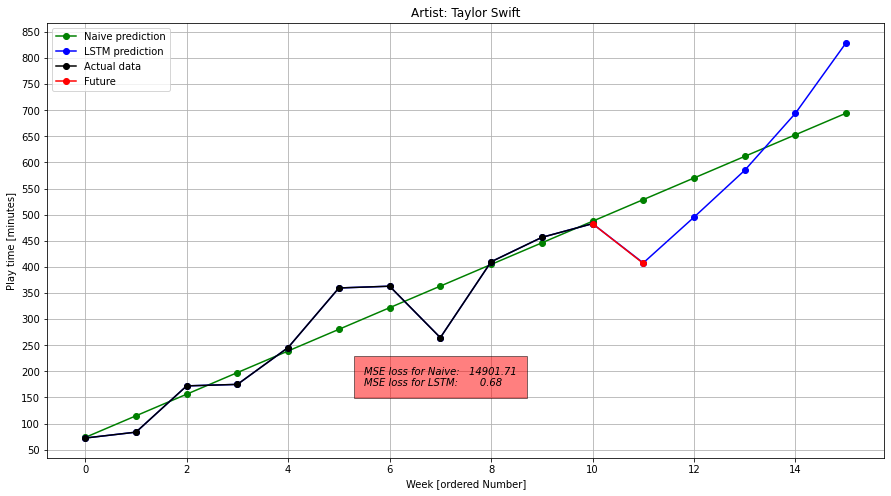

In [78]:
artists_to_display = ['Imagine Dragons', 'Radiohead', 'Taylor Swift']

for artist in artists_to_display:
  x, y = dataProvider.get_x_and_y([artist])
  plot_comparison(artist, x[0], y[0])

## Wnioski z porównania modeli

Wyraźnie widać, że model naiwny to prosty model liniowy, który nie bierzę pod uwagę okresowości danych i w najprostszy sposób próbuje dopasować się do szeregu czasowego. Zaproponowany model LSTM radzi sobie znacznie lepiej, osiąga błąd MSE nawet dwukrotnie mniejszy od naiwnego. Model LSTM osiąga na zbiorze testowym MSE równe 687.3561040972294, co ponad dwukrotnie przebija MSE modelu naiwnego na tym samym zbiorze (1283.3469113569847).